In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.preprocessing import OneHotEncoder
import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [2]:
df_tritrig = pd.read_pickle('/Users/mghrear/data/ML_data//BDT_2019_tritrig.pk')
df_tritrig['PhiKK'] = 0.0
df_tritrig = df_tritrig.sample(frac=1, random_state=42).reset_index(drop=True) # Now shuffle the combined dataframe
df_phiKK = pd.read_pickle('/Users/mghrear/data/ML_data//BDT_2019_phiKK.pk')
df_phiKK['PhiKK'] = 1.0
df_wab = pd.read_pickle('/Users/mghrear/data/ML_data//BDT_2019_wab.pk')
df_wab['PhiKK'] = 0.0 # Add label
df_wab = df_wab.sample(frac=1, random_state=42).reset_index(drop=True) # Now shuffle the combined dataframe
df_data = pd.read_pickle('/Users/mghrear/data/ML_data//BDT_2019_data.pk')

print("tritrig: ", len(df_tritrig))
print("phiKK: ", len(df_phiKK))
print("wab: ", len(df_wab))
print("data: ", len(df_data))

tritrig:  253700
phiKK:  5276
wab:  16360
data:  6439171


In [3]:
# Make Training set
tritrig_train = df_tritrig[0:20000]
wab_train = df_wab[0:4000]
phiKK_train = df_phiKK[0:4000]


df_train = pd.concat([tritrig_train, phiKK_train, wab_train], ignore_index=True, sort=False)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True) # Now shuffle the combined dataframe

X_train = df_train.drop(columns=['PhiKK'])
Y_train = df_train['PhiKK']

# Make testing set
tritrig_test = df_tritrig[20000:]
tritrig_test['type']= 'tritrig'
wab_test = df_wab[4000:]
wab_test['type']= 'wab'
phiKK_test = df_phiKK[4000:]
phiKK_test['type']= 'phiKK'

df_test = pd.concat([tritrig_test, phiKK_test,wab_test], ignore_index=True, sort=False)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True) # Now shuffle the combined dataframe

X_test = df_test.drop(columns=['PhiKK','type'])
Y_test = df_test['PhiKK']

# Make data set
X_final = df_data




/var/folders/fx/czrkltw953xcpcjd85tf2tmm0000gn/T/ipykernel_72183/1957775326.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tritrig_test['type']= 'tritrig'
/var/folders/fx/czrkltw953xcpcjd85tf2tmm0000gn/T/ipykernel_72183/1957775326.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wab_test['type']= 'wab'
/var/folders/fx/czrkltw953xcpcjd85tf2tmm0000gn/T/ipykernel_72183/1957775326.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [4]:
print("tritrig: ", len(tritrig_test))
print("phiKK: ", len(phiKK_test))
print("wab: ", len(wab_test))


tritrig:  233700
phiKK:  1276
wab:  12360


In [5]:
# Use AdaBoostClassifier with DecisionTreeClassifier as the base model
base_tree = DecisionTreeClassifier(random_state=0)
#model = AdaBoostClassifier(base_estimator = DTC)
clf = AdaBoostClassifier(estimator=base_tree)

In [6]:
# Use GridSearchCV to optimize hyper parameters
# The parameter search can be increased as desired, I do a pretty small search
param_grid = {"estimator__criterion" : ["gini"],
              "estimator__splitter" : ["best"],
              "estimator__max_depth": [2,3],
              "n_estimators": [50,75]
             }


grid_search_ABC = GridSearchCV(clf, param_grid=param_grid, scoring = 'roc_auc', n_jobs=-1,cv=3)

grid_search_ABC.fit(X_train, Y_train)

,estimator,AdaBoostClass...ndom_state=0))
,param_grid,"{'estimator__criterion': ['gini'], 'estimator__max_depth': [2, 3], 'estimator__splitter': ['best'], 'n_estimators': [50, 75]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [7]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_search_ABC.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_search_ABC.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search_ABC.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    random_state=0),
                   n_estimators=75)

 The best score across ALL searched params:
 0.9993283851088335

 The best parameters across ALL searched params:
 {'estimator__criterion': 'gini', 'estimator__max_depth': 3, 'estimator__splitter': 'best', 'n_estimators': 75}


Test model accuracy: 0.9979!
Test AUROC: 0.9981


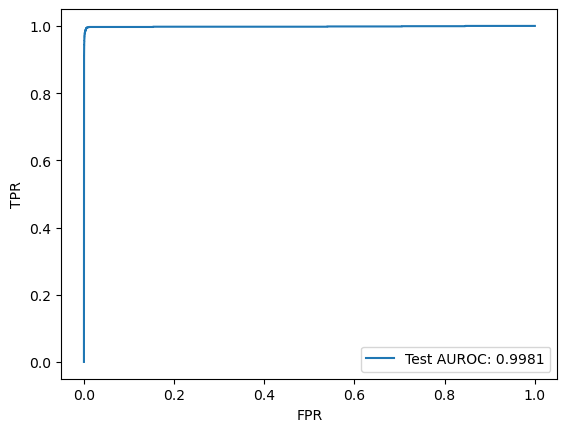

In [8]:
# Use the optimized model to evaluate performance on the held out validation set.
accuracy_test = np.mean(grid_search_ABC.best_estimator_.predict(X_test) == Y_test)
print(f'Test model accuracy: {accuracy_test:0.4f}!')

Yhat_test = grid_search_ABC.best_estimator_.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y_test, Yhat_test, pos_label=1)
auc_test = sklearn.metrics.auc(fpr, tpr)
print(f'Test AUROC: {auc_test:0.4f}')

plt.plot(fpr, tpr, label=f'Test AUROC: {auc_test:0.4f}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()


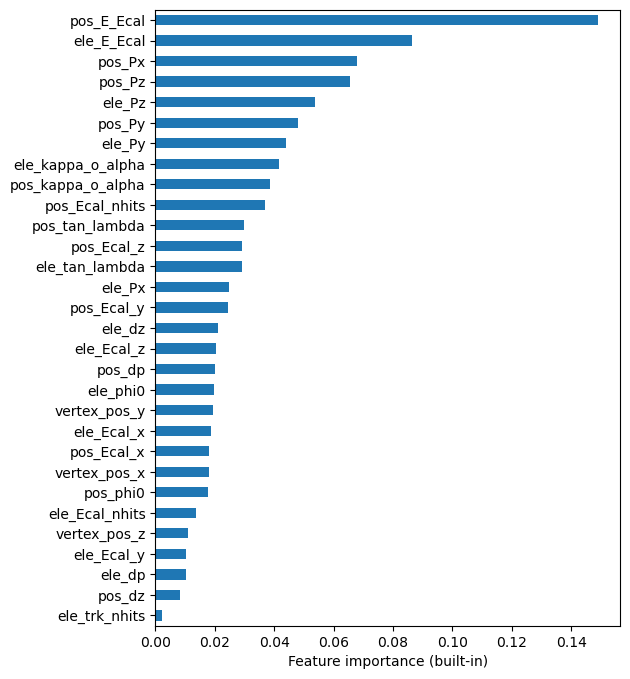

In [9]:
best = grid_search_ABC.best_estimator_
feat_names = X_train.columns
importances = best.feature_importances_
imp_series = pd.Series(importances, index=feat_names).sort_values(ascending=False)
imp_series.head(30).plot(kind='barh', figsize=(6,8))
plt.gca().invert_yaxis()
plt.xlabel('Feature importance (built-in)')
plt.show()


In [10]:
# Collect all test info into a dataframe
df_test['Yhat'] = Yhat_test


# Calculate invariant mass and add to dataframe
m_K = 0.493677
# Calculate total electron momentum
df_test['e_Ptot'] = np.sqrt(df_test['ele_Px']**2 + df_test['ele_Py']**2 + df_test['ele_Pz']**2)
# Calculate total positron momentum
df_test['p_Ptot'] = np.sqrt(df_test['pos_Px']**2 + df_test['pos_Py']**2 + df_test['pos_Pz']**2)
df_test['e_SVT_E_K'] = m_K / np.sqrt ( 1 - ( df_test.e_Ptot**2 / (df_test.e_Ptot**2  + m_K**2) ) )
df_test['p_SVT_E_K'] = m_K / np.sqrt ( 1 - ( df_test.p_Ptot**2 / (df_test.p_Ptot**2  + m_K**2) ) )
df_test['M'] = np.sqrt((df_test.e_SVT_E_K+df_test.p_SVT_E_K)**2 - (df_test.ele_Px+df_test.pos_Px)**2 - (df_test.ele_Py+df_test.pos_Py)**2 - (df_test.ele_Pz+df_test.pos_Pz)**2)

In [11]:
df_test.to_pickle("/Users/mghrear/data/ML_data/BDT_results.pk")

In [12]:
# Split into tritrig and phiKK dataframes
test_df_tritrig = df_test[df_test['type']=="tritrig"].reset_index(drop=True)
test_df_phiKK = df_test[df_test['type']=="phiKK"].reset_index(drop=True)
test_df_wab = df_test[df_test['type']=="wab"].reset_index(drop=True)


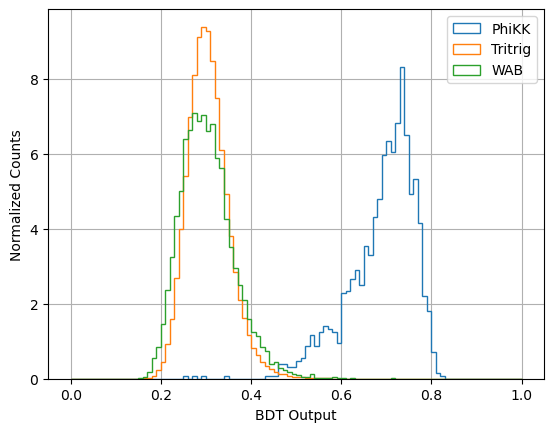

In [13]:
test_df_phiKK.Yhat.hist(bins=np.arange(0,1.01,0.01), histtype='step', label='PhiKK',density=True)
test_df_tritrig.Yhat.hist(bins=np.arange(0,1.01,0.01), histtype='step', label='Tritrig',density=True)
test_df_wab.Yhat.hist(bins=np.arange(0,1.01,0.01), histtype='step', label='WAB',density=True)
#plt.axvline(x=0.4, color='k', linestyle='--', label ="selection line")
plt.xlabel('BDT Output')
plt.ylabel('Normalized Counts')
plt.legend()

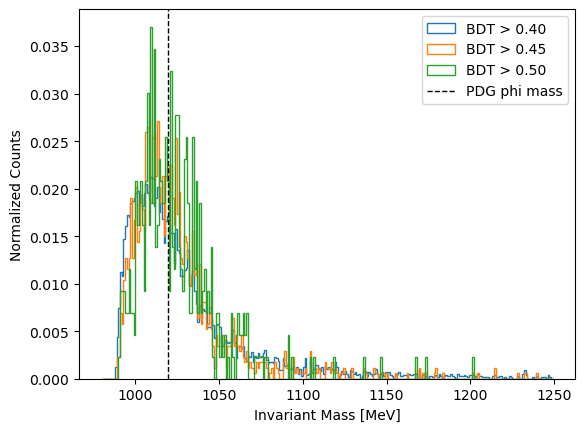

In [14]:
for sel in np.arange(0.4,0.51,0.05):

    df_tritrig_cut = test_df_tritrig[test_df_tritrig['Yhat']>sel].reset_index(drop=True)

    x_vals = 1000*df_tritrig_cut.M

    plt.hist(x_vals, bins=np.arange(980,1250,1), histtype='step', label=f'BDT > {sel:.2f}', density=True)

plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Normalized Counts')
plt.legend()

In [15]:
len(test_df_tritrig)

233700

In [16]:
len(test_df_wab)


12360

In [17]:
# Compine dfs according to expected proportions
df_test_combined = pd.concat([test_df_tritrig[0:45102], test_df_wab, test_df_phiKK[0:34]], ignore_index=True, sort=False)

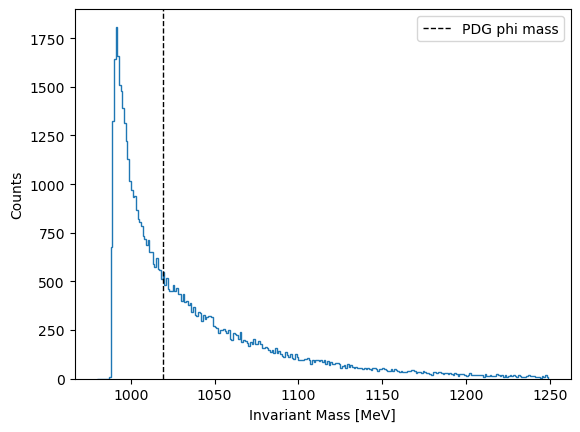

In [18]:
x_vals = 1000*df_test_combined.M
plt.hist(x_vals, bins=np.arange(980,1250,1), histtype='step')
plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Counts')
plt.legend()

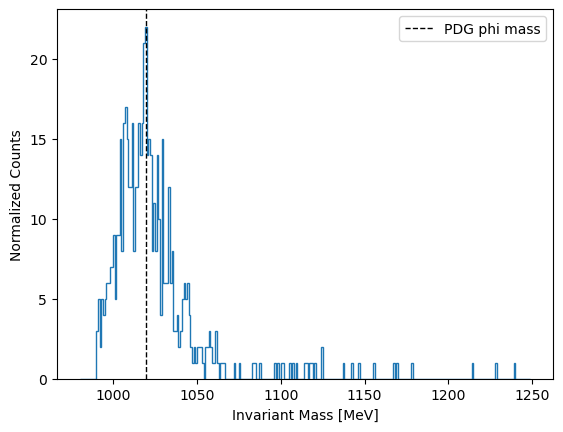

In [19]:
df_test_combined_cut = df_test_combined[df_test_combined['Yhat']>0.45].reset_index(drop=True)
x_vals = 1000*df_test_combined_cut.M
plt.hist(x_vals, bins=np.arange(980,1250,1), histtype='step')
plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Normalized Counts')
plt.legend()

In [20]:
Yhat_final = grid_search_ABC.best_estimator_.predict_proba(X_final)[:,1]


In [21]:
# Collect all test info into a dataframe
final_df = pd.DataFrame(X_final, columns=X_train.columns)
final_df['Yhat'] = Yhat_final


# Calculate invariant mass and add to dataframe
m_K = 0.493677
# Calculate total electron momentum
final_df['e_Ptot'] = np.sqrt(final_df['ele_Px']**2 + final_df['ele_Py']**2 + final_df['ele_Pz']**2)
# Calculate total positron momentum
final_df['p_Ptot'] = np.sqrt(final_df['pos_Px']**2 + final_df['pos_Py']**2 + final_df['pos_Pz']**2)
final_df['e_SVT_E_K'] = m_K / np.sqrt ( 1 - ( final_df.e_Ptot**2 / (final_df.e_Ptot**2  + m_K**2) ) )
final_df['p_SVT_E_K'] = m_K / np.sqrt ( 1 - ( final_df.p_Ptot**2 / (final_df.p_Ptot**2  + m_K**2) ) )
final_df['M'] = np.sqrt((final_df.e_SVT_E_K+final_df.p_SVT_E_K)**2 - (final_df.ele_Px+final_df.pos_Px)**2 - (final_df.ele_Py+final_df.pos_Py)**2 - (final_df.ele_Pz+final_df.pos_Pz)**2)

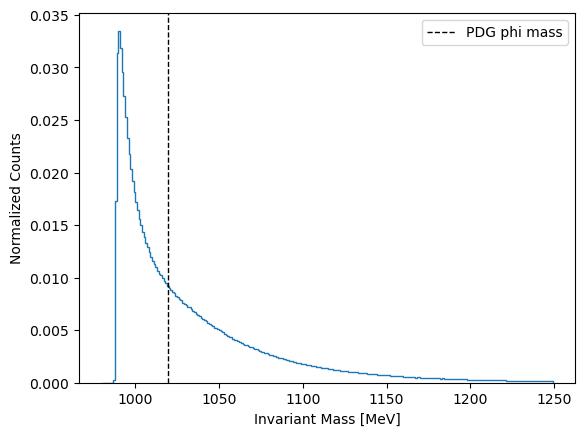

In [22]:
x_vals = 1000*final_df.M
plt.hist(x_vals, bins=np.arange(980,1250,1), histtype='step', density=True)
plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Normalized Counts')
plt.legend()

21


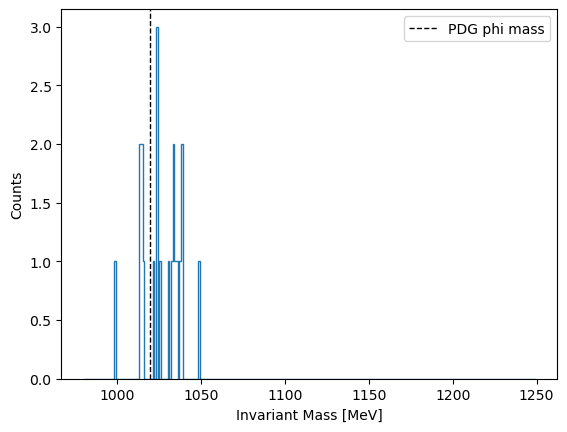

In [23]:
final_df_cut = final_df[final_df['Yhat']>0.8].reset_index(drop=True)
x_vals = 1000*final_df_cut.M

print(len(x_vals))
plt.hist(x_vals, bins=np.arange(980,1250,1), histtype='step')
plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Counts')
plt.legend()

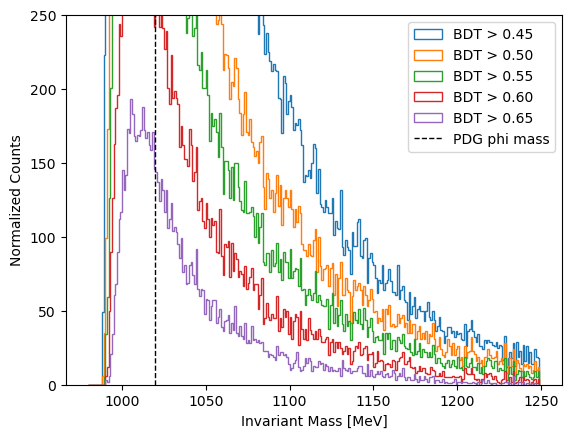

In [24]:
for sel in np.arange(0.45,0.7,0.05):

    final_df_cut = final_df[final_df['Yhat']>sel].reset_index(drop=True)
    x_vals = 1000*final_df_cut.M

    plt.hist(x_vals, bins=np.arange(980,1250,1), histtype='step', label=f'BDT > {sel:.2f}')

plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Normalized Counts')
plt.ylim(0,250)
plt.legend()

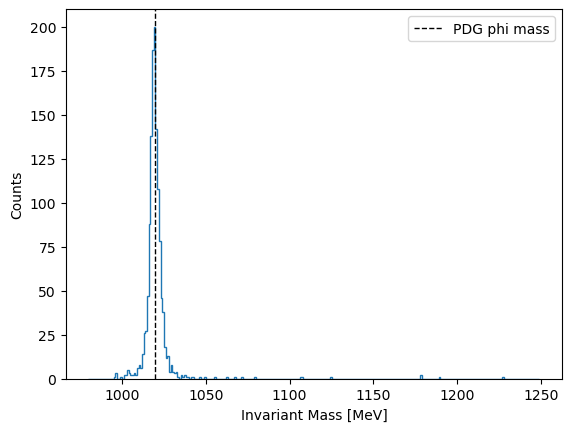

In [25]:
x_vals = 1000*test_df_phiKK.M
plt.hist(x_vals, bins=np.arange(980,1250,1), histtype='step')
plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Counts')
plt.legend()